## Survival mutations: coefficients/predictions analysis

In this notebook, we want to look a bit closer at what features are being selected in the predictions -> survival analysis, to get an idea of which genes are used by the model and what their predictions look like.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

In [2]:
# set results directories
results_dir = Path(cfg.results_dirs['survival'], 'mutations_me_all')

# set list of PCA component numbers to look for
n_pcs = 10

In [3]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'vogelstein_mutations': 'all Vogelstein mutations',
    'significant_mutations': 'significant mutations',
    'mutation_preds_expression': 'mutation scores, expression',
    'mutation_preds_me_27k': 'mutation scores, 27k',
    'mutation_preds_me_450k': 'mutation scores, 450k',
}

### Pan-cancer models

In [4]:
def is_feature_covariate(features):
    sample_info_df = du.load_sample_info('expression')
    cancer_types = list(sample_info_df.cancer_type.unique())
    covariate_names = cancer_types + ['age', 'log10_mut']
    return [(f in covariate_names) for f in features]

In [5]:
cancer_type = 'pancancer'
training_data = 'mutation_preds_me_450k'
seed = 42
fold = 0

coefs_file = '{}_{}_signal_survival_s{}_coefficients.tsv.gz'.format(
    cancer_type, training_data, seed)
coefs_file = results_dir / coefs_file

coefs_df = pd.read_csv(coefs_file, sep='\t')
coefs_df = coefs_df.loc[coefs_df.fold == fold, :].copy()
coefs_df['is_covariate'] = is_feature_covariate(coefs_df.feature)
coefs_df.head()

,feature,weight,abs,signal,seed,identifier,training_data,fold,is_covariate
0,LAML,1.9178,1.9178,signal,42,pancancer,mutation_preds_me_450k,0,True
1,LGG,1.4822,1.4822,signal,42,pancancer,mutation_preds_me_450k,0,True
2,GBM,1.3341,1.3341,signal,42,pancancer,mutation_preds_me_450k,0,True
3,UCEC,-1.0680,1.0680,signal,42,pancancer,mutation_preds_me_450k,0,True
4,BRCA,-1.0294,1.0294,signal,42,pancancer,mutation_preds_me_450k,0,True


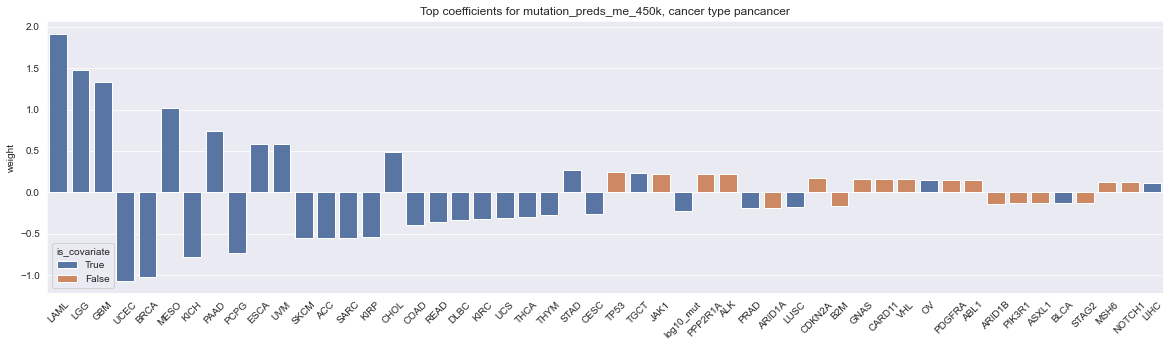

In [6]:
sns.set({'figure.figsize': (20, 5)})

plot_df = (coefs_df
    .sort_values(by='abs', ascending=False)
    .iloc[:50, :]
    .reset_index()
)

sns.barplot(data=plot_df, x=plot_df.index, y=plot_df.weight,
            dodge=False, hue='is_covariate', hue_order=[True, False])
plt.title('Top coefficients for {}, cancer type {}'.format(training_data, cancer_type))
plt.gca().set_xticklabels(plot_df.feature)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(45)

In [7]:
data_type = training_data.replace('mutation_preds_', '')

predictions_file = cfg.predictions[data_type]
preds_df = pd.read_csv(predictions_file, sep='\t', index_col=0)
preds_df.index.rename('sample_id', inplace=True)
print(preds_df.shape)
preds_df.head()

(7706, 124)


,ABL1,ACVR1B,AKT1,ALK,APC,AR,ARID1A,ARID1B,ARID2,ASXL1,...,STK11,TET2,TNFAIP3,TRAF7,TP53,TSC1,TSHR,U2AF1,VHL,WT1
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4390-01,-0.304581,115168.814497,6536.306317,-0.030281,0.273604,0.246140,1.269063,1.850487,-1.957170,0.869668,...,1.825473,0.947286,-2.081635,0.426831,0.128732,-79.226503,-13.374004,-242608.553451,-2.038592,-9125.998508
TCGA-05-4410-01,0.051010,39893.834138,-3025.713996,0.419930,0.301790,0.275314,0.734590,0.547627,0.502922,1.072803,...,0.841629,-0.057354,-0.137620,0.181784,4.204718,-377.374130,-19.936925,187294.452830,-1.354810,1394.691225
TCGA-05-5425-01,0.075634,-11479.711545,-10342.510183,0.303465,0.206659,-0.484738,0.300897,1.486566,-1.243162,0.869195,...,1.016552,-0.770744,-1.071302,-0.068058,1.929771,-558.862985,-11.322573,-699763.580601,-1.795855,4147.865293
TCGA-05-5715-01,-0.661257,83497.980451,6906.620748,0.113682,-0.029230,0.672134,-1.268555,0.323393,-1.002562,0.511036,...,2.592167,-0.303888,-1.495371,0.069205,-2.993326,-2113.441293,-22.593039,216969.739741,-1.393146,-30756.295346
TCGA-06-0125-01,-0.510944,13275.861181,-6850.612169,-0.993108,-3.669849,-0.753381,-3.336156,-1.448184,-3.392017,-0.687123,...,-0.979643,-0.680072,-1.198582,-0.446892,-2.642565,-1131.575561,-31.349891,117901.799122,-2.296689,14145.804041


In [8]:
pancan_data = du.load_pancancer_data(verbose=True)
mutation_df = pancan_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

Loading pan-cancer data from cached pickle file...


(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [11]:
# gene = 'IDH1'
gene = 'CARD11'
plot_df = preds_df[[gene]].merge(mutation_df[[gene]],
                                 left_index=True, right_index=True)
plot_df.rename(columns={'{}_x'.format(gene): 'pred_scores',
                        '{}_y'.format(gene): 'is_mutated'},
               inplace=True)
plot_df['pred_prob'] = 1 / (1 + np.exp(-plot_df.pred_scores))
print(plot_df.shape)
print(plot_df.pred_prob.min())
print(plot_df.pred_prob.max())
plot_df.head()

(7706, 3)
0.0013592656595809098
0.9945050688479706


,pred_scores,is_mutated,pred_prob
TCGA-05-4390-01,1.634651,0,0.836806
TCGA-05-4410-01,2.185887,0,0.898975
TCGA-05-5425-01,0.304002,1,0.575421
TCGA-05-5715-01,0.420354,0,0.603568
TCGA-06-0125-01,2.993760,0,0.952291


Text(0, 0.5, 'Predicted mutation probability')

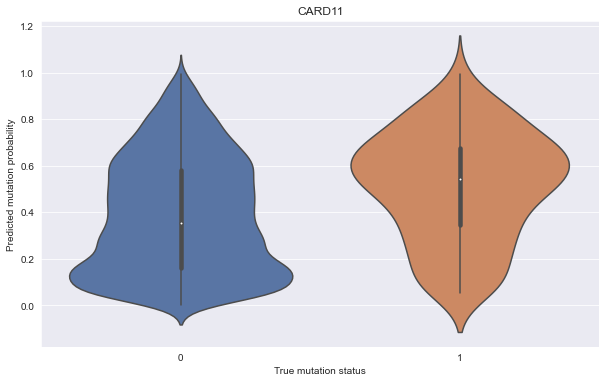

In [12]:
sns.set({'figure.figsize': (10, 6)})
sns.violinplot(data=plot_df, x='is_mutated', y='pred_prob')
plt.title(gene)
plt.xlabel('True mutation status')
plt.ylabel('Predicted mutation probability')